# Khanh Truong - Coline Merlen (Web Mining | March 2019)

### =========================================================================================

### README:
    In order to better follow this notebook:
   1. It's *necessary* to read carefully the **Headers** (Markdown cells), **Output** (tables and graphs) and beginning **Comments** of each cell.
   2. It's *NOT necessary* to read every line of code and its comment.
    

### =========================================================================================

# Graph Approach



### Assumption: Fake news is more likely to be posted by unreliable users.
### Steps:
    1. For each user, calculate unreliable score.
        - Unreliable score of a user is based on two metrics:
            + Percenatge of fake news that the user posts - fake_percent
            (A user is more unreliable if the user posts many fake news.)
            + Average percenatge of fake news that the followees of that user posts - followee_fake_percent
            (A user is more unreliable if the user's followees post many fake news.)
        - Unreliable score of a user = p*fake_percent + (1-p)*followee_fake_percent
        
    2. For each news, calculate the unreliable score.
        - Unreliable score of news = Average unreliable score of every user posts the news
        - Given a threshold, news will be considered as fake if unreliable score of the news is greater than the threshold.
    
    3. Choose the optimal threshold of news fake score which maximizes F-measure.
        (split data into training and testing sets to avoid overfitting issue when choosing threshold)

## Import library

In [102]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os
from datetime import datetime
import pickle

import warnings
warnings.filterwarnings(action='once')

## Import data

Number of nodes: 23865
Number of edges: 408824
Size of 5 largest connected components: [23618, 6, 6, 4, 4]


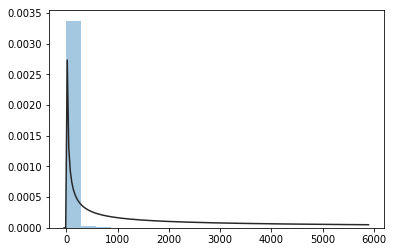

In [103]:
# Import graph data
g = nx.read_adjlist('fake-news-prediction-toulouse/data_competition/UserUser.txt') # graph

print('Number of nodes: {}'.format(len(g.node)))
print('Number of edges: {}'.format(len(g.edges)))

deg = nx.degree(g) # calculate degree of nodes in the graph
df = pd.Series([y for (x,y) in deg])
sns.distplot(df, bins=20, kde=False, fit=stats.powerlaw);

cc = [len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)] # size of connected components
print('Size of 5 largest connected components: {}'.format(cc[0:5]))
largest_cc = max(nx.connected_component_subgraphs(g), key=len) # extract the largest connected component

In [104]:
# Import label data
label = pd.read_csv('fake-news-prediction-toulouse/data_competition/labels_training.txt', sep=',')
label.columns = ['news', 'fake'] # fake := 1 if the news is fake

# Split into train and test sets
label_train, label_test = train_test_split(label, test_size=0.2, random_state=1234)

print('% fake in whole set: {}'.format(label.fake.mean()))
print('% fake in train set: {}'.format(label_train.fake.mean()))

label_train.head()
# From now on, only label_train is used to train the model.

% fake in whole set: 0.5025906735751295
% fake in train set: 0.4935064935064935


,news,fake
97,122,1
149,188,1
39,51,0
25,33,0
130,164,1


In [105]:
# Import news user data
news_user = pd.read_csv('fake-news-prediction-toulouse/data_competition/newsUser.txt', sep='\t', header=None)
news_user.columns = ['news', 'user', 'time']
news_user.head()

,news,user,time
0,240,1,1
1,124,2,1
2,162,3,1
3,233,4,1
4,50,5,1


## Calculate fake percentage of user
    "A user is more unrelibale if he/she posts many fake news."

In [106]:
# Merge label to news user
news_user_label = news_user.merge(label_train, left_on='news', right_on='news', how='left', copy=False)
news_user_label = news_user_label[~news_user_label.fake.isnull()] # not NA in column 'fake' (have label)
news_user_label.fake = news_user_label.fake.astype(int) # remove decimal in column 'fake'
news_user_label['fake_count'] = news_user_label['fake']*news_user_label['time'] # fake scaled by the times of posting
news_user_label.head()

,news,user,time,fake,fake_count
0,240,1,1,1,1
2,162,3,1,1,1
3,233,4,1,1,1
4,50,5,1,0,0
6,227,7,1,1,1


In [107]:
# Calculate percentage fake news posted by each user
user_fake_percent = news_user_label.groupby('user').agg({'time':'sum', # for each user, calculate total posting
                                                         'fake_count':'sum'}) # calculate total fake
user_fake_percent.columns = ['news_count','fake_count']
user_fake_percent['fake_percent'] = user_fake_percent['fake_count']/user_fake_percent['news_count'] # percentage of fake
user_fake_percent.sort_values(['fake_percent','news_count'], ascending=False, inplace=True) # sort value
user_fake_percent.head()

,news_count,fake_count,fake_percent
user,,,
19924,67,67,1.0
13973,45,45,1.0
8040,41,41,1.0
9584,40,40,1.0
4715,35,35,1.0


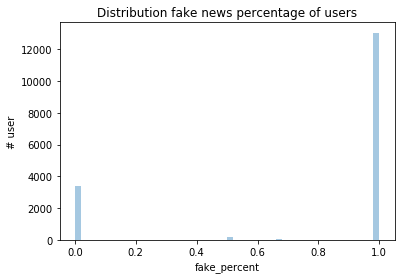

In [108]:
plt.rcParams['figure.figsize'] = [6, 4]
ax = sns.distplot(user_fake_percent['fake_percent'], kde=False)
ax.set(xlabel='fake_percent',
       ylabel='# user',
       title='Distribution fake news percentage of users');

# Most of the users post only fake news (100% of fake news).
# Some others don't post any fake news (0%).
# Very few users are in the between.

## Calculate average fake percentage of user's followees
    "A user is more unreliable if he/she follows unreliable people."

In [109]:
# Import user network data
user_user = pd.read_csv('fake-news-prediction-toulouse/data_competition/UserUser.txt', sep='\t', header=None)
user_user.columns = ['user', 'user_followee']
user_user = user_user.sort_values(['user','user_followee']).reset_index(drop=True)
user_user.head()

,user,user_followee
0,1,1589
1,1,11421
2,1,13267
3,1,17196
4,1,22926


,fake_percent,followee_fake_percent
user,,
1,1.0,1.000000
3,1.0,0.882353
4,1.0,0.545455
5,0.0,0.806643
7,1.0,1.000000


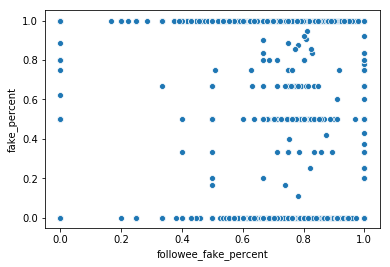

In [110]:
# Calculate average percentage of fake news posted by a user's followees
followee_fake_percent = user_user \
    .merge(user_fake_percent[['fake_percent']], left_on='user_followee', right_index=True, how='left') \
    .groupby('user').agg({'fake_percent':np.mean})

followee_fake_percent.columns = ['followee_fake_percent']
followee_fake_percent = followee_fake_percent[~followee_fake_percent.followee_fake_percent.isna()] # remove 

followee_fake_percent = user_fake_percent[['fake_percent']] \
    .merge(followee_fake_percent, left_index=True, right_index=True, how='outer')


sns.scatterplot(data=followee_fake_percent,
               x='followee_fake_percent',
               y='fake_percent');

followee_fake_percent.head()

In [111]:
# Assume 'unreliable score' of a user is determined 50% by his/her fake percent, and 50% by his/her friends' fake percent
p = 0.5
followee_fake_percent['unreliable_score'] = p*followee_fake_percent['fake_percent'] \
                                            + (1-p)*followee_fake_percent['followee_fake_percent']
followee_fake_percent.head()

,fake_percent,followee_fake_percent,unreliable_score
user,,,
1,1.0,1.000000,1.000000
3,1.0,0.882353,0.941176
4,1.0,0.545455,0.772727
5,0.0,0.806643,0.403322
7,1.0,1.000000,1.000000


## For each news, calculate average unreliable score of users post that news
    "News is more unreliable if it is posted by many unreliable users."

In [112]:
# Unreliable_score of news on training set
# Keep the column 'fake' (the actual label) to compare with unreliable_score

train_pred = label_train \
    .merge(news_user, left_on='news', right_on='news', how='left') \
    .merge(followee_fake_percent[['unreliable_score']], left_on='user', right_index=True, how='left') \
    .groupby('news').agg({'unreliable_score':np.mean}) \
    .merge(label_train, left_index=True, right_on='news', how='left') \
    .set_index('news')
train_pred.head()

,unreliable_score,fake
news,,
1,0.444374,0
3,0.454698,0
5,0.381975,0
6,0.475535,0
8,0.463382,0


In [113]:
# Unreliable_score of news on testing set
# Keep the column 'fake' (the actual label) to compare with unreliable_score

test_pred = label_test \
    .merge(news_user, left_on='news', right_on='news', how='left') \
    .merge(followee_fake_percent[['unreliable_score']], left_on='user', right_index=True, how='left') \
    .groupby('news').agg({'unreliable_score':np.mean}) \
    .merge(label_test, left_index=True, right_on='news', how='left') \
    .set_index('news')
test_pred.head()

,unreliable_score,fake
news,,
9,0.463382,0
10,0.401671,0
11,0.547857,0
13,0.633541,0
38,0.750000,0


## Make prediction based on unreliable score of news - Choose optimal threshold
    "News is more likely to be fake if it has high unreliable score."

In [114]:
# Given a threshold, news is considered as fake if the fake_score is greater than the threshold.
# How to choose threshold?
# Loop through many thresholds from 0 to 1, calculate the f-measure at each level of threshold

threshold = []
f_measure_train = []
f_measure_test = []

for threshold_i in np.linspace(0, 1, 101):

    f_measure_train_i = f1_score(y_true=train_pred['fake'],
                                 y_pred=[int(x>threshold_i) for x in train_pred['unreliable_score']])
    
    f_measure_test_i = f1_score(y_true=test_pred['fake'],
                                y_pred=[int(x>threshold_i) for x in test_pred['unreliable_score']])
    
    f_measure_train.append(f_measure_train_i)
    f_measure_test.append(f_measure_test_i)
    threshold.append(threshold_i)
    
f_measure = pd.DataFrame([threshold, f_measure_train, f_measure_test]).transpose()
f_measure.columns = ['threshold' , 'f_measure_train', 'f_measure_test']
f_measure.set_index('threshold', inplace=True)
f_measure.head()

,f_measure_train,f_measure_test
threshold,,
0.00,0.657895,0.7
0.01,0.657895,0.7
0.02,0.657895,0.7
0.03,0.657895,0.7
0.04,0.657895,0.7


Maximum F-measure on testing set is 0.9047619047619048


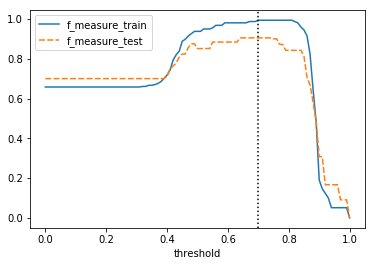

In [115]:
print('Maximum F-measure on testing set is {}'.format(np.max(f_measure_test)))

sns.lineplot(data=f_measure)
plt.axvline(x=0.7, color='black', linestyle=':');

# It's obvious that f measure on training set is always greater than testing set, given a threshold.
# Regardless, the f measure reaches the peak at threshold=0.7
# choose threshold := 0.7

## Choose optimal p
    "What makes a user be unreliable: himself or his friends?"

    - Note that the above prediction is made based on unreliable_score, which is calculated by
    0.5*fake_percent + 0.5*followee_fake_percent (p=0.5).
    - We now comeback to choose the optimal p.
    - Unreliable score of a user should base entirely on himself (p=1) or entirely on his friends (p=0)?
    - As demonstrated above, when p=0.5, the maximum F-measure we can obtain on testing set is 0.90476.
    - We will loop though many p, ranging from 0 to 1, let's see how maximum F-measure evolves.

In [116]:
p = []
f_measure_max_train = []
f_measure_max_test = []

f_measure_mean_train = []
f_measure_mean_test = []

for p_i in np.linspace(0, 1, 101): # loop through many p values from 0 to 1, step=0.01, at each p:
    
    # Calculate unreliable_score of each user
    followee_fake_percent['unreliable_score'] = p_i*followee_fake_percent['fake_percent'] \
                                                + (1-p_i)*followee_fake_percent['followee_fake_percent']
    followee_fake_percent['unreliable_score'].fillna(followee_fake_percent['fake_percent'], inplace=True)
    followee_fake_percent['unreliable_score'].fillna(followee_fake_percent['followee_fake_percent'], inplace=True)

    
    # Calculate unreliable_score of each news on training set
    train_pred = label_train \
        .merge(news_user, left_on='news', right_on='news', how='left') \
        .merge(followee_fake_percent[['unreliable_score']], left_on='user', right_index=True, how='left') \
        .groupby('news').agg({'unreliable_score':np.mean}) \
        .merge(label_train, left_index=True, right_on='news', how='left') \
        .set_index('news')
    
    # Calculate unreliable_score of each news on testing set
    test_pred = label_test \
        .merge(news_user, left_on='news', right_on='news', how='left') \
        .merge(followee_fake_percent[['unreliable_score']], left_on='user', right_index=True, how='left') \
        .groupby('news').agg({'unreliable_score':np.mean}) \
        .merge(label_test, left_index=True, right_on='news', how='left') \
        .set_index('news')

    
    # Store max and average F-measure at each threshold level
    f_measure_max_train_p = 0
    f_measure_max_test_p = 0
    
    f_measure_mean_train_p = []
    f_measure_mean_test_p = []
    
    for threshold_i in np.linspace(0, 1, 101):
        
        f_measure_train_p = f1_score(y_true=train_pred['fake'],
                                     y_pred=[int(x>threshold_i) for x in train_pred['unreliable_score']])
        
        f_measure_test_p = f1_score(y_true=test_pred['fake'],
                                    y_pred=[int(x>threshold_i) for x in test_pred['unreliable_score']])
            
        f_measure_max_train_p = f_measure_train_p if (f_measure_train_p > f_measure_max_train_p) else f_measure_max_train_p
        f_measure_max_test_p = f_measure_test_p if (f_measure_test_p > f_measure_max_test_p) else f_measure_max_test_p
        
        f_measure_mean_train_p.append(f_measure_train_p)
        f_measure_mean_test_p.append(f_measure_test_p)
        
        
    # Append max F-measure
    f_measure_max_train.append(f_measure_max_train_p)
    f_measure_max_test.append(f_measure_max_test_p)
    
    # Append average F-measure
    f_measure_mean_train_p = np.mean(f_measure_mean_train_p)
    f_measure_mean_test_p = np.mean(f_measure_mean_test_p)
    
    f_measure_mean_train.append(f_measure_mean_train_p)
    f_measure_mean_test.append(f_measure_mean_test_p)
    
    # Append p
    p.append(p_i)
    

f_measure = pd.DataFrame([p,
                          f_measure_max_train, f_measure_max_test,
                          f_measure_mean_train, f_measure_mean_test]).transpose()
f_measure.columns = ['p',
                     'f_measure_max_train', 'f_measure_max_test',
                     'f_measure_mean_train', 'f_measure_mean_test']
f_measure.set_index('p', inplace=True)
f_measure.head()

,f_measure_max_train,f_measure_max_test,f_measure_mean_train,f_measure_mean_test
p,,,,
0.00,0.980392,0.888889,0.666298,0.610474
0.01,0.980392,0.888889,0.669501,0.611264
0.02,0.980392,0.888889,0.672240,0.612587
0.03,0.980392,0.888889,0.675392,0.615127
0.04,0.980392,0.888889,0.677960,0.616835


Highest F-measure on testing set is 0.9767441860465117


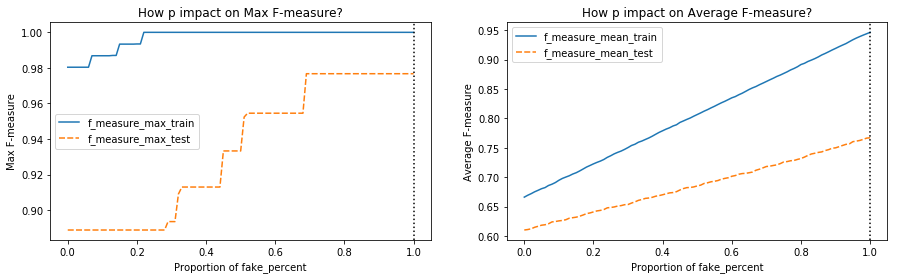

In [117]:
print('Highest F-measure on testing set is {}'.format(np.max(f_measure_max_test)))

plt.rcParams['figure.figsize'] = [15, 4] # size of plot
fig, axs = plt.subplots(ncols=2)

ax = sns.lineplot(data=f_measure[['f_measure_max_train', 'f_measure_max_test']], ax=axs[0])
ax.set(xlabel='Proportion of fake_percent',
       ylabel='Max F-measure',
       title='How p impact on Max F-measure?')
ax.axvline(x=1.0, color='black', linestyle=':');


bx = sns.lineplot(data=f_measure[['f_measure_mean_train', 'f_measure_mean_test']], ax=axs[1])
bx.set(xlabel='Proportion of fake_percent',
       ylabel='Average F-measure',
       title='How p impact on Average F-measure?')
bx.axvline(x=1.0, color='black', linestyle=':');

    - Remind: For each user: unreliable_score = p*fake_percent + (1-p)*followee_fake_percent
              For each news: unreliable_score = Average users' unreliable_score
              
    - At each value of p (proportion of fake_perfent), we calculate unreliable_score of evey users, then calculate
    unreliable_score of every news, then calculate maximum F-measure possible.
    So for each p, we have one value of maximum F-measure.

    - Interestingly, at p=1, the maximum F-measure we can obtain is 0.97674, which is greater than any other values of p.
    - Therefore, unreliable score of a user should base completely on himself (p=1) because at p=1 we get highest max
    F-measure (and highest average F-measure).

## Calculate centrality measures of user
    "Are centrality measures associated with reliable level of users?"

In [118]:
# Load centrality measures
with open('Temporary_Files/degree.pickle', 'rb') as handle:
    degree = pickle.load(handle)
    
with open('Temporary_Files/closeness.pickle', 'rb') as handle:
    closeness = pickle.load(handle)

with open('Temporary_Files/eigenvector.pickle', 'rb') as handle:
    eigenvector = pickle.load(handle)

with open('Temporary_Files/katz.pickle', 'rb') as handle:
    katz = pickle.load(handle)

with open('Temporary_Files/betweenness.pickle', 'rb') as handle:
    betweenness = pickle.load(handle)    

In [119]:
centrality = pd.concat([pd.Series(degree),
                        pd.Series(closeness),
                        pd.Series(eigenvector),
                        pd.Series(katz),
                        pd.Series(betweenness)],
                      axis=1)

centrality.columns = ['degree' ,'closeness', 'eigenvector', 'katz', 'betweenness']
centrality.index = centrality.index.astype(int)
centrality.index.name = 'user'
centrality.head()

,degree,closeness,eigenvector,katz,betweenness
user,,,,,
507,0.000461,0.313734,0.000146,0.006121,0.000242
1,0.000335,0.290649,0.000788,-0.002283,0.000003
1589,0.009261,0.339624,0.018251,-0.023112,0.000062
5307,0.000796,0.327333,0.002286,-0.001020,0.000022
11421,0.004903,0.341899,0.018435,-0.007095,0.000020


## Examine realtionship between fake score and centrality measures of user

In [120]:
user_profile = followee_fake_percent \
    .merge(user_fake_percent[['news_count']], left_index=True, right_index=True, how='left') \
    .merge(centrality, left_index=True, right_index=True, how='left')

user_profile.head()

,fake_percent,followee_fake_percent,unreliable_score,news_count,degree,closeness,eigenvector,katz,betweenness
user,,,,,,,,,
1,1.0,1.000000,1.0,1.0,0.000335,0.290649,0.000788,-0.002283,0.000003
3,1.0,0.882353,1.0,1.0,0.002347,0.397290,0.002666,-0.026034,0.000371
4,1.0,0.545455,1.0,1.0,0.001173,0.365630,0.002683,0.002735,0.000049
5,0.0,0.806643,0.0,1.0,0.010350,0.403239,0.004829,-0.005675,0.001194
7,1.0,1.000000,1.0,1.0,0.000168,0.277350,0.000018,0.000462,0.000087


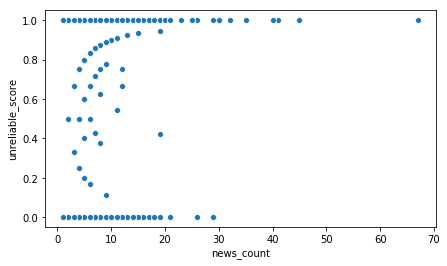

In [121]:
plt.rcParams['figure.figsize'] = [7, 4] # size of plot
sns.scatterplot(data=user_profile,
                x='news_count',
                y='unreliable_score');
# Users post more GENERALLY have more unreliable_score. Nevertheless, the relationship is not strong.

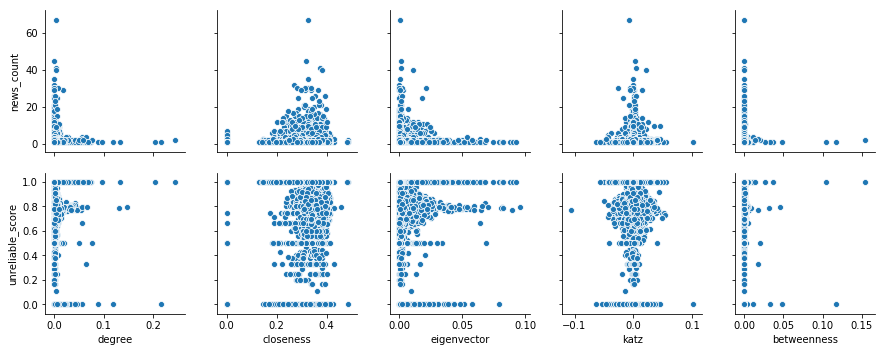

In [122]:
sns.pairplot(data = user_profile,
             x_vars = ['degree', 'closeness', 'eigenvector', 'katz', 'betweenness'],
             y_vars = ['news_count', 'unreliable_score']);

    There seems no relationship between unreliable_score|news_count and the user centrality measures.
    As a result, we don't take the centrality measures into 'unreliable score' of a user.

    We have also used graph clustering methods with the hope that "Users post more fake news will be in the same clusters".
    However, the our cluster results do not separate well reliable users and unreliable users.

## For submission

In [123]:
# The above analysis is perform on training label set, i.e. we didn't use all the data to train model.
# For the final model, we need to calculate again the user unreliable score based on whole available data.
# The steps are exactly identical as above, just replace "label_train" by "label" data.

# Merge label to news user
news_user_label = news_user.merge(label, left_on='news', right_on='news', how='left', copy=False)
news_user_label = news_user_label[~news_user_label.fake.isnull()] # not NA in column fake (have label)
news_user_label['fake_count'] = news_user_label['fake']*news_user_label['time'] # fake scaled by the times of posting

# Calculate percentage fake news posted by each user
user_fake_percent = news_user_label.groupby('user').agg({'time':'sum', # for each user, calculate total posting
                                                         'fake_count':'sum'}) # calculate total fake
user_fake_percent.columns = ['news_count','fake_count']
user_fake_percent['fake_percent'] = user_fake_percent['fake_count']/user_fake_percent['news_count'] # percentage of fake
user_fake_percent.sort_values(['fake_percent','news_count'], ascending=False, inplace=True) # sort value

# Calculate percentage fake news posted by each user's followees
followee_fake_percent = user_user \
    .merge(user_fake_percent[['fake_percent']], left_on='user_followee', right_index=True, how='left') \
    .groupby('user').agg({'fake_percent':np.mean})
followee_fake_percent.columns = ['followee_fake_percent']
followee_fake_percent = followee_fake_percent[~followee_fake_percent.followee_fake_percent.isna()] # remove 
followee_fake_percent = user_fake_percent[['fake_percent']] \
    .merge(followee_fake_percent, left_index=True, right_index=True, how='outer')

# Calculate unreliable score of news
final_pred = news_user.merge(label, left_on='news', right_on='news', how='left', copy=False)
final_pred = final_pred \
    .loc[final_pred.fake.isnull(),:] \
    .merge(followee_fake_percent[['fake_percent','followee_fake_percent']], left_on='user', right_index=True, how='left') \
    .groupby('news').agg({'fake_percent':np.mean,
                          'followee_fake_percent':np.mean})

# If a news is posted by users who all don't have fake_percent, take the followee_fake_percent to determine if the news is fake
final_pred['fake_percent'].fillna(final_pred['followee_fake_percent'], inplace=True)
final_pred.drop('followee_fake_percent', axis=1, inplace=True)
final_pred.columns = ['unreliable_score']

# Calculate fake prediction
threshold = 0.7
final_pred['fake_pred'] = [int(x>threshold) for x in final_pred['unreliable_score']]

final_pred.head()

,unreliable_score,fake_pred
news,,
2,0.246488,0
4,0.303571,0
7,0.252778,0
16,0.032407,0
17,0.135556,0


### =========================================================================================

# Text Approach

### Steps:
    We are going to apply two methods of text mining: Naive Bayes Classifier (NB) and Support Vector Machines (SVM).
    
    Steps at each method:
        - Train model
        - Choose optimal parameters for the model
        - Choose threshold and valuate model
        
    Before applying the two machine learning algorithms, we use text-preprocess techniques (token) and tf-idf representation in order to transform the data into appropriate form to apply the models.

In [124]:
from gensim.models import Word2Vec

import nltk
from nltk.corpus import twitter_samples, stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.collocations import *
from nltk import tokenize

import glob
import re

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV

## Example one document

In [126]:
f = open(file="fake-news-prediction-toulouse/data_competition/news/training/1.txt", mode='r', encoding="utf8")
print(f.read())

Trump Just Insulted Millions Who Lost Everything In Bush's Recession, "That's Just Business"

16.8k SHARES SHARE THIS STORY

Hillary Clinton just called out the fact that Donald Trump cheered for the housing crisis in anticipation of its collapse – which is absolutely true. Trump told The Globe and Mail in March of 2007: “People have been talking about the end of the cycle for 12 years, and I’m excited if it is. I’ve always made more money in bad markets than in good markets.”

In fact, Trump thought the housing crisis was much-ado-do about nothing for high-end investments, and told investors: “I don’t see the subprime problems affecting the higher-end stuff…In fact, he is advising investors that there are now great deals in buying subprime mortgages at a discount and repossessed houses at low prices.”

Of course, on one level, Trump wasn’t wrong­­—in that the subprime crisis affected mostly poorer Americans who lost their homes and jobs and the ability to support their families. The c

In [127]:
with open ('fake-news-prediction-toulouse/data_competition/news/training/1.txt', encoding="utf8") as fin:
    words = tokenize.word_tokenize(fin.read())

In [128]:
words_lower = [w.lower() for w in words if w.isalpha] # lower case if the word is whole alphabet
words_rm_stop = [w for w in words_lower if not w in stopwords.words('english')] # remove stop words
words_tag = nltk.pos_tag(words_rm_stop) # POS tagging
noun_verb = [w[0] for w in words_tag if w[1].startswith(('NN', 'VB'))] # keep either nouns or verbs
noun_verb_stem = [PorterStemmer().stem(w) for w in noun_verb] # strem
noun_verb_stem[0:10]

['trump',
 'insult',
 'million',
 'lost',
 'everyth',
 'bush',
 'recess',
 'busi',
 'share',
 'share']

In [129]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_bi = BigramCollocationFinder.from_words(noun_verb_stem)
finder_bi.nbest(score_fn=bigram_measures.pmi, n=10)

[('abil', 'support'),
 ('action', 'presid'),
 ('add', 'name'),
 ('burden', 'payment'),
 ('buy', 'mortgag'),
 ('congress', 'take'),
 ('cours', 'level'),
 ('crime', 'impeach'),
 ('cycl', 'year'),
 ('deal', 'buy')]

In [130]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder_tri = TrigramCollocationFinder.from_words(noun_verb_stem)
finder_tri.nbest(score_fn=trigram_measures.pmi, n=10)

[('abil', 'support', 'famili'),
 ('burden', 'payment', 'incom'),
 ('buy', 'mortgag', 'discount'),
 ('congress', 'take', 'action'),
 ('cycl', 'year', 'excit'),
 ('deal', 'buy', 'mortgag'),
 ('demand', 'congress', 'take'),
 ('job', 'abil', 'support'),
 ('made', 'money', 'market'),
 ('money', 'market', 'markets.')]

In [131]:
finder_bi = BigramCollocationFinder.from_words(noun_verb_stem)
finder_bi.apply_freq_filter(1)
finder_bi.nbest(score_fn=bigram_measures.pmi, n=10)

[('abil', 'support'),
 ('action', 'presid'),
 ('add', 'name'),
 ('burden', 'payment'),
 ('buy', 'mortgag'),
 ('congress', 'take'),
 ('cours', 'level'),
 ('crime', 'impeach'),
 ('cycl', 'year'),
 ('deal', 'buy')]

In [132]:
b = Word2Vec([noun_verb_stem], min_count=1)
b.wv.most_similar(positive=["trump"])

[('equiti', 0.15568086504936218),
 ('thought', 0.13307404518127441),
 ('problem', 0.13017040491104126),
 ('million', 0.124514639377594),
 ('discount', 0.11307623982429504),
 ('home', 0.10667358338832855),
 ('payment', 0.10384444892406464),
 ('mail', 0.08498071879148483),
 ('everyth', 0.07415523380041122),
 ('congress', 0.07332486659288406)]

## For whole data

## Import data

In [133]:
# Merge all the news into one list 'documents'
file_list = glob.glob('./fake-news-prediction-toulouse/data_competition/news/training' + '/*.txt')
documents = []
for filename in file_list:
    with open(filename, 'r', encoding="utf8") as f:
        documents.append(f.read().replace('\n', ' ')) # remove blank line
        
print('There are {} news in the training set. Following is one example news:'.format(len(documents)))
documents[0]

There are 193 news in the training set. Following is one example news:


'Trump Just Insulted Millions Who Lost Everything In Bush\'s Recession, "That\'s Just Business"  16.8k SHARES SHARE THIS STORY  Hillary Clinton just called out the fact that Donald Trump cheered for the housing crisis in anticipation of its collapse – which is absolutely true. Trump told The Globe and Mail in March of 2007: “People have been talking about the end of the cycle for 12 years, and I’m excited if it is. I’ve always made more money in bad markets than in good markets.”  In fact, Trump thought the housing crisis was much-ado-do about nothing for high-end investments, and told investors: “I don’t see the subprime problems affecting the higher-end stuff…In fact, he is advising investors that there are now great deals in buying subprime mortgages at a discount and repossessed houses at low prices.”  Of course, on one level, Trump wasn’t wrong\xad\xad—in that the subprime crisis affected mostly poorer Americans who lost their homes and jobs and the ability to support their famili

In [134]:
# The order of news in 'documents' is shuffled.
# Therefore, we need to match the label according to the order of news in documents.

news_ID = [re.search(r'\d+', i).group(0) for i in file_list] # extract the news ID in news path
news_ID = [int(i) for i in news_ID] # covert to integer
news_ID = pd.DataFrame(news_ID)
news_ID.columns = ['news']

documents_label = news_ID.merge(label, left_on='news', right_on='news', how='left')
documents_label = documents_label['fake']
documents_label.head()

0    0
1    0
2    0
3    0
4    0
Name: fake, dtype: int64

In [135]:
# Split into train and tests set
# Note that using identical random_state when spliting documents and documents_lable to make sure the order is ensured.
documents_train, documents_test = train_test_split(documents, test_size=0.2, random_state=1234)
documents_label_train, documents_label_test = train_test_split(documents_label, test_size=0.2, random_state=1234)

## Naive Bayes (NB) classifier

###### Train model

In [136]:
# Use pipeline to train model
text_nb = Pipeline([('vect', CountVectorizer()), # token counts
                    ('tfidf', TfidfTransformer()), # tf-idf representation
                    ('clf', MultinomialNB())]) # Naive Bayes classifier

text_nb = text_nb.fit(documents_train, documents_label_train) # train model

###### Choose optimal parameters in model

In [137]:
# Load the GridSearch result
with open('Temporary_Files/gs_nb.pickle', 'rb') as handle:
    gs_nb = pickle.load(handle)

In [138]:
# best parameters in GridSearch
gs_nb.best_params_

{'clf__alpha': 0.01,
 'clf__fit_prior': True,
 'tfidf__norm': 'l1',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': True,
 'tfidf__use_idf': True,
 'vect__binary': False,
 'vect__max_df': 0.8,
 'vect__min_df': 0.01,
 'vect__ngram_range': (1, 2),
 'vect__strip_accents': None}

###### Choose optimal threshold

In [139]:
# Given a threshold, news is considered as fake if the fake_score is greater than the threshold.
# How to choose threshold?
# Loop through many thresholds from 0 to 1, calculate the f-measure at each level of threshold

threshold = []
f_measure_train = []
f_measure_test = []

for threshold_i in np.linspace(0, 1, 11):

    f_measure_train_i = f1_score(y_true=documents_label_train,
                                 y_pred=[int(x[1]>threshold_i) for x in gs_nb.predict_proba(documents_train)])
    
    f_measure_test_i = f1_score(y_true=documents_label_test,
                                y_pred=[int(x[1]>threshold_i) for x in gs_nb.predict_proba(documents_test)])
   
    f_measure_train.append(f_measure_train_i)
    f_measure_test.append(f_measure_test_i)
    threshold.append(threshold_i)
    
f_measure = pd.DataFrame([threshold, f_measure_train, f_measure_test]).transpose()
f_measure.columns = ['threshold' , 'f_measure_train', 'f_measure_test']
f_measure.set_index('threshold', inplace=True)
f_measure.head()

,f_measure_train,f_measure_test
threshold,,
0.0,0.666667,0.677966
0.1,0.666667,0.677966
0.2,0.666667,0.677966
0.3,0.675439,0.677966
0.4,0.709677,0.677966


Maximum F-measure on testing set is 0.83721


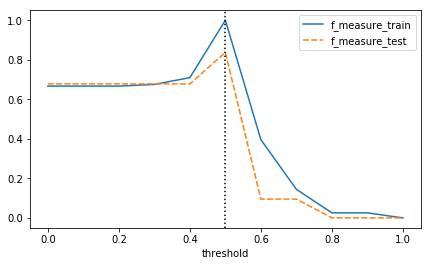

In [140]:
print('Maximum F-measure on testing set is {0:.5f}'.format(np.max(f_measure_test)))

sns.lineplot(data=f_measure)
plt.axvline(x=0.5, color='black', linestyle=':');

# It's obvious that f measure on training set is always greater than testing set, given a threshold.
# Regardless, the f measure reaches the peak at threshold=0.5
# choose threshold := 0.5

## Support Vector Machines (SVM)

###### Train model

In [141]:
text_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('svm', SGDClassifier())])

text_svm = text_svm.fit(documents_train, documents_label_train)

###### Choose optimal parameters in model

In [142]:
# Load the GridSearch result
with open('Temporary_Files/gs_svm.pickle', 'rb') as handle:
    gs_svm = pickle.load(handle)

In [143]:
gs_svm.best_params_

{'svm__alpha': 0.0001,
 'svm__loss': 'hinge',
 'svm__penalty': 'l2',
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': True,
 'tfidf__use_idf': True,
 'vect__binary': True,
 'vect__max_df': 0.9,
 'vect__min_df': 0.0,
 'vect__ngram_range': (1, 2),
 'vect__strip_accents': None}

In [144]:
# F measure of SVM method
f1_score(y_true=documents_label_test,
         y_pred=gs_svm.predict(documents_test))

0.8636363636363635

### =========================================================================================

# Conclusion

   So far, we have applied two approaches: graph mining and text mining.
   - **In graph mining**, we measure unrelibale score of a news based on people post that news. If a news is posted by people who usually post fake news, the news will be more likely to be considered as fake. 
   - **In text mining**, Support Vector Machines obtains higher F-measure than Naive Bayes classifier does. Nevertheless, these two methods do not get 1.000 of F-measure like graph mining approach does.
   
   => We use *graph* model to predict on the target unknown-label data set.

#### -------------------------------------------------------------------------------------------------------------------------------------------------------------- Khanh Truong - Coline Merlen